<a href="https://www.kaggle.com/code/kursatdinc/garbage-classification-cnn?scriptVersionId=192545796" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Garbage Classification with Convolutional Neural Network (CNN)

### Content

1) Business Problem

2) Data Understanding

3) Data Preparation

4) Modeling

5) Evaluation

6) Testing

## 1) Business Problem

Garbage segregation involves separating wastes according to how it's handled or processed. It's important for recycling as some materials are recyclable and others are not.

## 2) Data Understanding

**Dataset Story** 

The dataset we will use in this project is the dataset called TrashNet. Prepared by Stanford University students.  

The data set consists of six different classes. There are a total of 2527 images in the data set, including Glass, Paper, Cardboard, Plastic, Metal and Garbage.  

**Distribution of images:** 

* 501 glass 
* 594 paper 
* 403 cardboard 
* 482 plastic 
* 410 metal 
* 137 trash 

Images were taken by placing them on a white board and using sunlight or room lighting. Images are 512 x 384 pixels in size and 3 (RGB) channels.

### 2.1) Importings

In [1]:
!pip install -q imutils

In [2]:
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

import warnings
warnings.filterwarnings("ignore")

2024-08-13 20:08:07.321024: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 20:08:07.321124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 20:08:07.452745: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### 2.2) Read Dataset

In [3]:
data_dir  = "/kaggle/input/garbage-classification/Garbage classification/Garbage classification"

classes = os.listdir(data_dir)
print(classes)

['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


In [4]:
target_size = (224, 224)

waste_labels = {"cardboard":0, "glass":1, "metal":2, "paper":3, "plastic":4, "trash":5}

In [5]:
def load_datasets(path):

    """ 
    It reads the image in the directory where the images are located and creates labels.
    
    Parameters: 
    
    path: It refers to the directory where the images are located.
    
    Return: 
    
    x: It holds the matrix information of the images.
    
    labels: The list that holds the class information to which the image belongs.
    """
    x = []
    labels = []

    # The images in the path we send are listed and sorted.
    image_paths = sorted(list(paths.list_images(path)))

    for image_path in image_paths:
        # Images in the specified path are read with the openCV library.
        img = cv2.imread(image_path)

        # The read images are rescaled according to the initially specified target_size.
        img = cv2.resize(img, target_size)

        # The scaled images are added to the x list.
        x.append(img)

        # When each path is separated by the "/" statement, the second to last element of the returned list represents the label.
        label = image_path.split(os.path.sep)[-2]

        # A label is created by taking the value value in response to the key value sent from the
        # waste_labels dictionary, which contains the numerical value equivalents of the captured labels.
        labels.append(waste_labels[label])

    # The data set is shuffled randomly.
    x, labels = shuffle(x, labels, random_state = 42)

    # Size and Class Information is reported.
    print(f"X Shape: {np.array(x).shape}")
    print(f"Label Class Count: {len(np.unique(labels))} Observation Count: {len(labels)}")

    return x, labels

In [6]:
x, labels = load_datasets(data_dir)

X Shape: (2527, 224, 224, 3)
Label Class Count: 6 Observation Count: 2527


In [7]:
# Keeping Image Dimensions
input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1], 3)
print(input_shape)

(224, 224, 3)


### 2.3) Visualizing Examples from the Dataset

In [8]:
def visualize_img(image_batch, label_batch):
    """
    Visualizes images from the data set.
    
    Parameters:
    
    image_batch: Keeps matrix information of images.
    
    label_batch: List containing the class information to which the image belongs.

    """
    plt.figure(figsize=(10,10))
    for n in range(10):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=6)[n]==1][0].title())
      plt.axis("off")

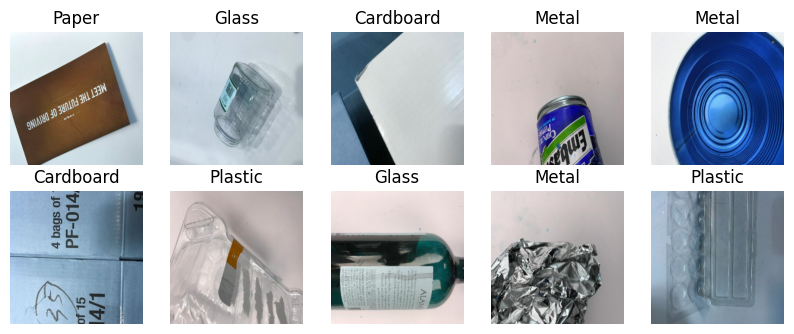

In [9]:
visualize_img(x, labels)

## 3) Data Preparation

In [10]:
# Define a generator for the train set.
train = ImageDataGenerator(horizontal_flip=True,
                           vertical_flip=True,
                           validation_split=0.1,
                           rescale=1./255,
                           shear_range=0.1,
                           zoom_range=0.1,
                           width_shift_range=0.1,
                           height_shift_range=0.1)

# Define a generator for the test set.
test = ImageDataGenerator(rescale=1/255,
                          validation_split=0.1)

In [11]:
train_generator = train.flow_from_directory(directory=data_dir,
                                            target_size=(target_size),
                                            class_mode="categorical",
                                            subset="training")

test_generator = test.flow_from_directory(directory=data_dir,
                                          target_size=(target_size),
                                          batch_size=251,
                                          class_mode="categorical",
                                          subset="validation")

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


## 4) Modeling

### 4.1) CNN Architecture

* Sequential
* Convolution Layer, Conv2D
* Pooling Layer
* Activation Layer
* Flattening Layer
* Dense Layer
* Dropout Layer

In [12]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", input_shape=(input_shape), activation="relu"))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Flatten())

model.add(Dense(units=64, activation="relu"))
model.add(Dropout(rate=0.2))
model.add(Dense(units=32, activation="relu"))
model.add(Dropout(rate=0.2))

model.add(Dense(units=6, activation="softmax"))

### 4.1) Model Summary

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,645,830 (6.28 MB)

 Trainable params: 1,645,830 (6.28 MB)

 Non-trainable params: 0 (0.00 B)

### 4.3) Adjusting Optimization and Evaluation Metrics

In [14]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "acc"])

In [15]:
callbacks = [EarlyStopping(monitor="val_loss", patience=50, verbose=1, mode="min"),
             ModelCheckpoint(filepath="garbage_classification_model.keras", monitor="val_loss", mode="min", save_best_only="True", save_weights_only=False, verbose=1)]

### 4.3) Model Training

In [16]:
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=test_generator,
                    callbacks=callbacks,
                    steps_per_epoch=2276//32,
                    validation_steps=251//32)

Epoch 1/100
 2/71 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - acc: 0.2188 - loss: 2.2979 - precision: 0.1000 - recall: 0.0469          

I0000 00:00:1723579726.701702     105 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723579726.724069     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - acc: 0.2053 - loss: 1.8877 - precision: 0.1867 - recall: 0.0118
Epoch 1: val_loss improved from inf to 1.72961, saving model to garbage_classification_model.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 61s 656ms/step - acc: 0.2053 - loss: 1.8864 - precision: 0.1867 - recall: 0.0116 - val_acc: 0.1992 - val_loss: 1.7296 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100


W0000 00:00:1723579772.486142     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 1/71 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - acc: 0.2812 - loss: 1.6704 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2: val_loss did not improve from 1.72961
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.2812 - loss: 1.6704 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_acc: 0.1992 - val_loss: 1.7309 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - acc: 0.2096 - loss: 1.7554 - precision: 0.1709 - recall: 0.0019
Epoch 3: val_loss improved from 1.72961 to 1.70877, saving model to garbage_classification_model.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 27s 341ms/step - acc: 0.2096 - loss: 1.7554 - precision: 0.1752 - recall: 0.0020 - val_acc: 0.2351 - val_loss: 1.7088 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
 1/71 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - acc: 0.2500 - loss: 1.7585 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4: val_loss did not improve from 1.70877
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - 

### 4.5) Accuracy and Loss Graphs

Text(0.5, 1.0, 'Training and Validation Accuracy')

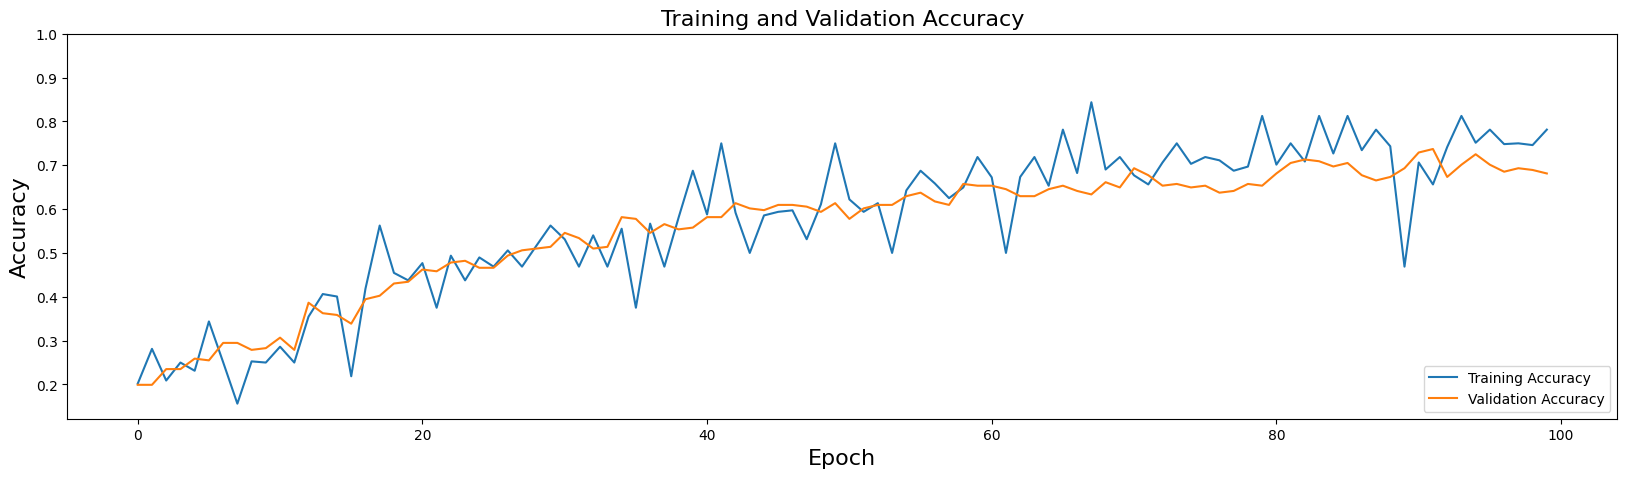

In [17]:
# Accuracy
plt.figure(figsize=(20, 5))
plt.plot(history.history["acc"], label="Training Accuracy")
plt.plot(history.history["val_acc"], label="Validation Accuracy")
plt.legend(loc="lower right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracy", fontsize=16)


Text(0.5, 1.0, 'Training and Validation Loss')

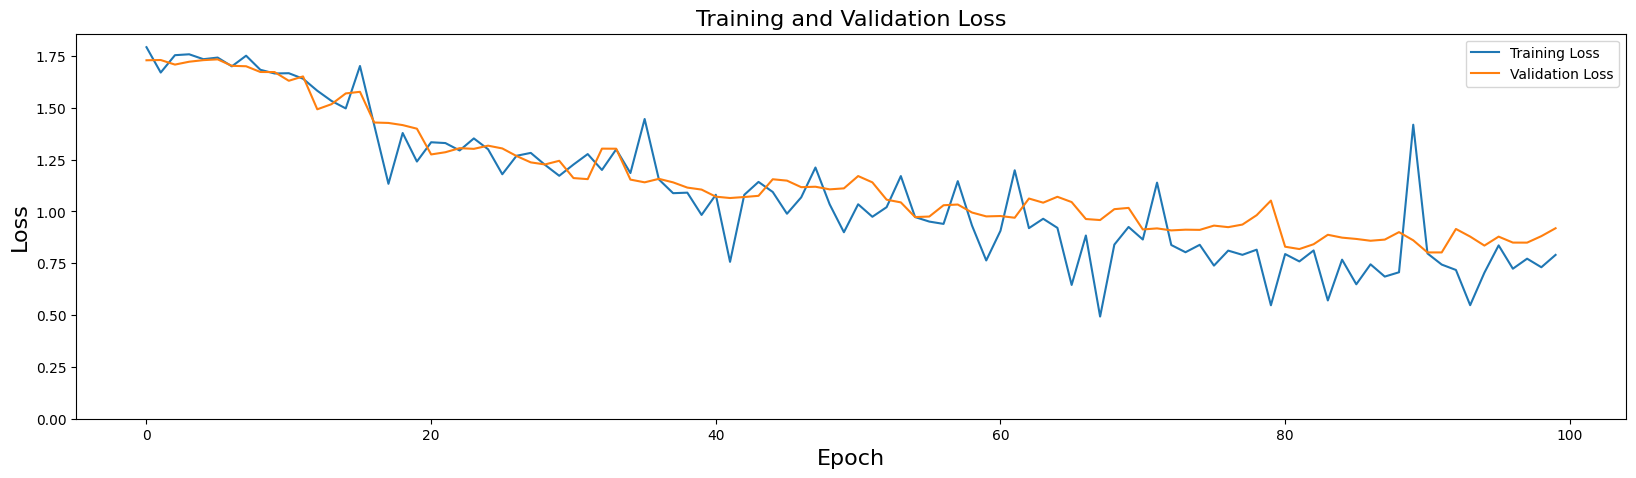

In [18]:
# Loss
plt.figure(figsize=(20, 5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title("Training and Validation Loss", fontsize=16)

## 5) Evaluation

In [19]:
loss, precision, recall, acc = model.evaluate(test_generator, batch_size=32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step - acc: 0.6813 - loss: 0.9191 - precision: 0.7219 - recall: 0.5378


In [20]:
print("\nTest Accuracy: %.1f%%" % (100.0 * acc))
print("\nTest Loss: %.1f%%" % (100.0 * loss))
print("\nTest Precision: %.1f%%" % (100.0 * precision))
print("\nTest Recall: %.1f%%" % (100.0 * recall))


Test Accuracy: 68.1%

Test Loss: 91.9%

Test Precision: 72.2%

Test Recall: 53.8%


In [21]:
# Classification Report
x_test, y_test = test_generator.__next__()

y_pred = model.predict(x_test)

y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 

W0000 00:00:1723581146.950085     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step


In [22]:
target_names = list(waste_labels.keys())
target_names

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [23]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   cardboard       0.79      0.82      0.80        40
       glass       0.70      0.62      0.66        50
       metal       0.57      0.68      0.62        41
       paper       0.76      0.81      0.79        59
     plastic       0.53      0.44      0.48        48
       trash       0.77      0.77      0.77        13

    accuracy                           0.68       251
   macro avg       0.69      0.69      0.69       251
weighted avg       0.68      0.68      0.68       251



In [24]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap='OrRd'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)  # Pass 'cm' as the first argument
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

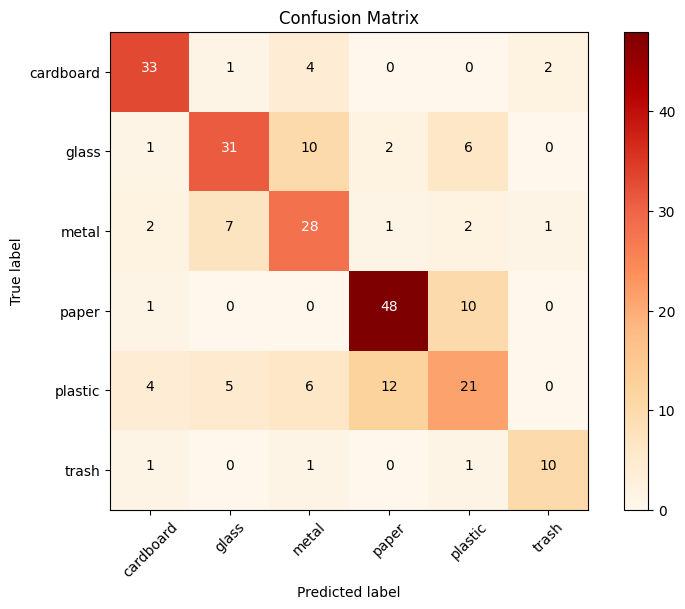

In [25]:
plot_confusion_matrix(cm, waste_labels.keys(),
                      title="Confusion Matrix",
                      cmap="OrRd")

## 6) Testing the Model

In [26]:
waste_labels = {0:"cardboard", 1:"glass", 2:"metal", 3:"paper", 4:"plastic", 5:"trash"}

In [27]:
def model_testing(path):
    """
    It reads the image in the directory where the images are located and makes a prediction about which class it belongs to through the model.      
    
    Parameters: 
    
    path: Refers to the directory where the images are located.  
    
    Return: 
    
    img: Image 
    
    p: Prediction probabilities 
    
    predicted_class: Prediction class

    """

    img = image.load_img(path, target_size=(target_size))
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img) / 255.0
    p = model.predict(img.reshape(1, 224, 224, 3))
    predicted_class = np.argmax(p[0])

    return img, p, predicted_class

In [28]:
img1, p1, predicted_class1 = model_testing(data_dir + "/metal/metal100.jpg")
img2, p2, predicted_class2 = model_testing(data_dir + "/glass/glass105.jpg")
img3, p3, predicted_class3 = model_testing(data_dir + "/cardboard/cardboard103.jpg")
img4, p4, predicted_class4 = model_testing(data_dir + "/paper/paper106.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


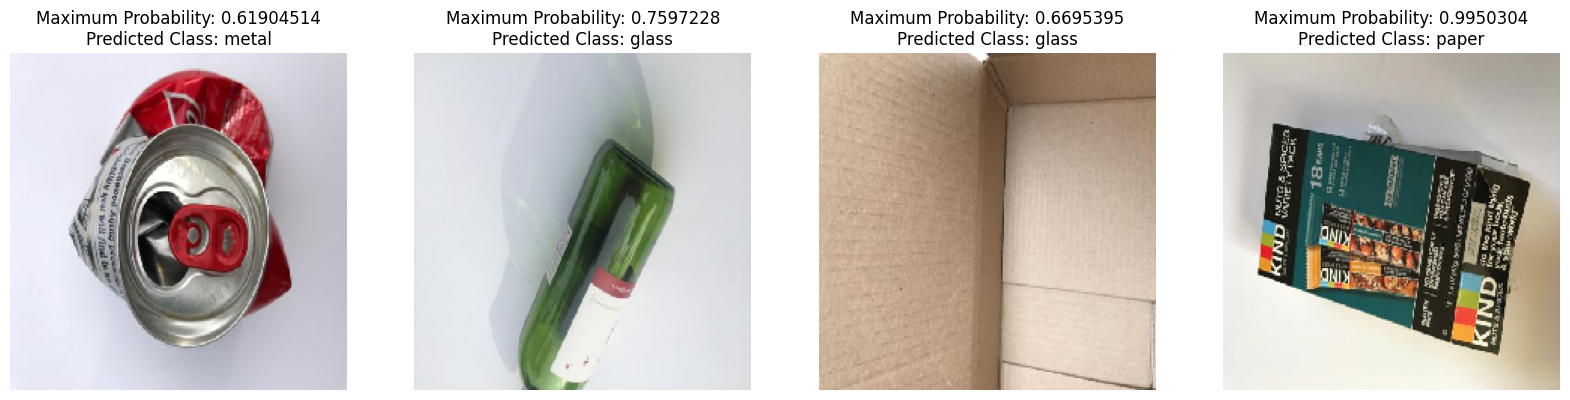

In [29]:
def safe_get_label(class_id, label_dict):
    return label_dict.get(class_id, "Unknown Class")

plt.figure(figsize=(20, 60))

plt.subplot(141)
plt.axis("off")
plt.imshow(img1.squeeze())
plt.title("Maximum Probability: " + str(np.max(p1[0], axis=-1)) + "\n" + "Predicted Class: " + safe_get_label(predicted_class1, waste_labels))
plt.imshow(img1)

plt.subplot(142)
plt.axis("off")
plt.imshow(img2.squeeze())
plt.title("Maximum Probability: " + str(np.max(p2[0], axis=-1)) + "\n" + "Predicted Class: " + safe_get_label(predicted_class2, waste_labels))
plt.imshow(img2)

plt.subplot(143)
plt.axis("off")
plt.imshow(img3.squeeze())
plt.title("Maximum Probability: " + str(np.max(p3[0], axis=-1)) + "\n" + "Predicted Class: " + safe_get_label(predicted_class3, waste_labels))
plt.imshow(img3)

plt.subplot(144)
plt.axis("off")
plt.imshow(img4.squeeze())
plt.title("Maximum Probability: " + str(np.max(p4[0], axis=-1)) + "\n" + "Predicted Class: " + safe_get_label(predicted_class4, waste_labels))
plt.imshow(img4)

plt.show()
